In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, accuracy_score
import numpy as np

# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class PlantDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.label_to_index = {"Early_Blight": 0, "Late_Blight": 1, "Healthy": 2}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.annotations.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = self.annotations.iloc[idx, 1]
        label = self.label_to_index[label]
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
train_dataset = PlantDataset(csv_file='train_metadata.csv',transform=data_transforms['train'])
val_dataset = PlantDataset(csv_file='valid_metadata.csv', transform=data_transforms['val'])
test_dataset = PlantDataset(csv_file='test_metadata.csv', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [9]:
model = models.resnet152(weights=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Suponiendo que tienes 3 clases

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [10]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): Cuántas épocas esperar después de la última mejora en el rendimiento de validación.
            verbose (bool): Si True, imprime un mensaje cada vez que se encuentra una mejora.
            delta (float): Umbral para considerar una mejora significativa.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Guarda el modelo cuando la pérdida de validación disminuye.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.val_loss_min = val_loss


In [12]:
# Inicializar EarlyStopping
early_stopping = EarlyStopping(patience=10, verbose=True)

num_epochs = 25

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Cada época tiene una fase de entrenamiento y validación
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Modo de entrenamiento
            dataloader = train_loader
        else:
            model.eval()  # Modo de validación
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        # Iterar sobre datos
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Poner a cero los gradientes
            optimizer.zero_grad()

            # Hacia adelante
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Hacia atrás y optimizar solo en la fase de entrenamiento
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        epoch_recall = recall_score(all_labels, all_preds, average='weighted')

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Recall: {epoch_recall:.4f}')

        # Aplicar early stopping en la fase de validación
        if phase == 'val':
            early_stopping(epoch_loss, model)

    # Detener el entrenamiento si se cumple la condición de early stopping
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Cargar el último modelo guardado (mejor modelo)
model.load_state_dict(torch.load('checkpoint.pth'))

Epoch 1/25
----------
train Loss: 0.5227 Acc: 0.7948 F1: 0.7960 Recall: 0.7948
val Loss: 0.2256 Acc: 0.9183 F1: 0.9179 Recall: 0.9183
Validation loss decreased (inf --> 0.225603).  Saving model ...
Epoch 2/25
----------
train Loss: 0.3451 Acc: 0.8690 F1: 0.8693 Recall: 0.8690
val Loss: 0.2162 Acc: 0.9135 F1: 0.9143 Recall: 0.9135
Validation loss decreased (0.225603 --> 0.216175).  Saving model ...
Epoch 3/25
----------
train Loss: 0.2733 Acc: 0.8970 F1: 0.8971 Recall: 0.8970
val Loss: 0.0888 Acc: 0.9760 F1: 0.9759 Recall: 0.9760
Validation loss decreased (0.216175 --> 0.088815).  Saving model ...
Epoch 4/25
----------
train Loss: 0.2434 Acc: 0.9139 F1: 0.9140 Recall: 0.9139
val Loss: 0.0844 Acc: 0.9808 F1: 0.9808 Recall: 0.9808
Validation loss decreased (0.088815 --> 0.084368).  Saving model ...
Epoch 5/25
----------
train Loss: 0.2523 Acc: 0.9108 F1: 0.9110 Recall: 0.9108
val Loss: 0.1293 Acc: 0.9688 F1: 0.9687 Recall: 0.9688
EarlyStopping counter: 1 out of 10
Epoch 6/25
----------
tr

<All keys matched successfully>

In [13]:
model.eval()
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convertir a arrays de NumPy para calcular métricas
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calcular métricas
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Recall: {test_recall:.4f}')


Test Accuracy: 0.9901
Test F1 Score: 0.9901
Test Recall: 0.9901


In [21]:
torch.save(model.state_dict(), 'final_model_resnet_152.pth')

GradCam

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [15]:

class GradCAM:
    def __init__(self, model, target_layer_names):
        self.model = model
        self.target_layer_names = target_layer_names
        self.gradients = []
        self.activations = []

        for name, module in self.model.named_modules():
            if name in self.target_layer_names:
                module.register_forward_hook(self.save_activation)
                module.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations.append(output)
    
    def save_gradient(self, module, grad_in, grad_out):
        self.gradients.append(grad_out[0])

    def __call__(self, x, index=None):
        self.gradients = []
        self.activations = []
        
        output = self.model(x)
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        
        self.model.zero_grad()
        class_loss = output[0, index]
        class_loss.backward()

        gradients = self.gradients[-1].cpu().data.numpy()[0]
        activations = self.activations[-1].cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


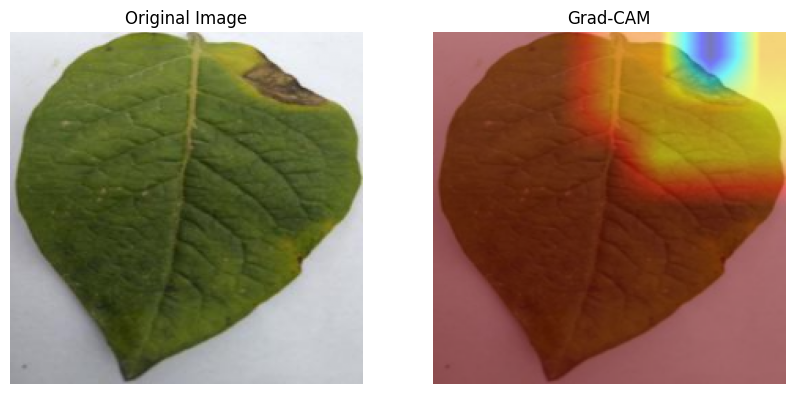

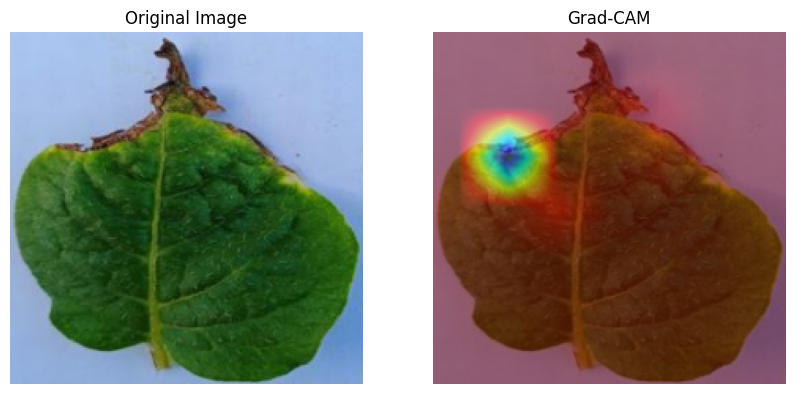

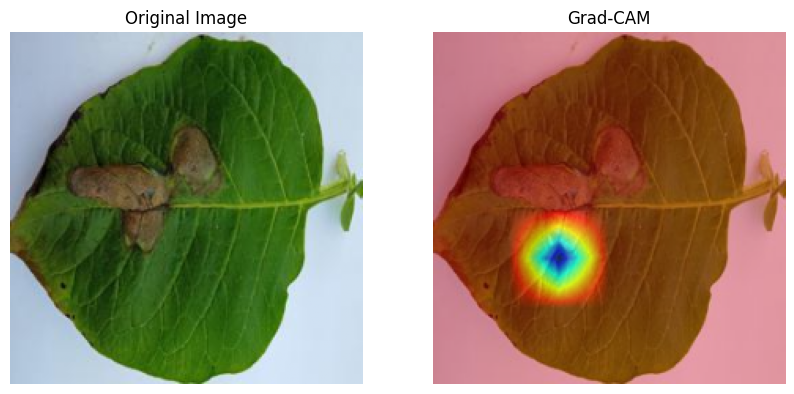

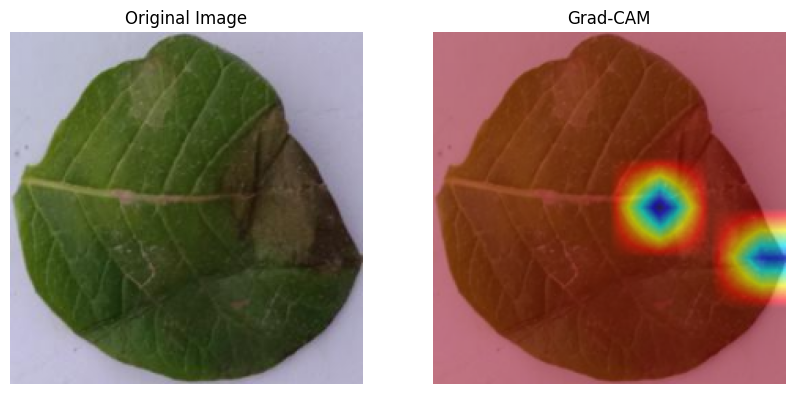

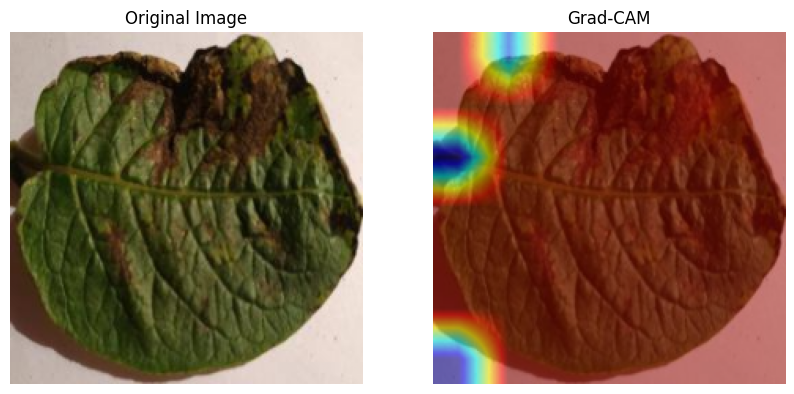

In [20]:
# Definir la capa objetivo para Grad-CAM
target_layer_names = ["layer4.2.conv3"]

# Inicializar Grad-CAM
grad_cam = GradCAM(model, target_layer_names)

# Función para mostrar imágenes y mapas de calor
def visualize_cam(img_path, model, grad_cam):
    # Preprocesar la imagen
    image = Image.open(img_path).convert("RGB")
    transform = data_transforms['test']
    input_img = transform(image).unsqueeze(0).to(device)
    
    # Obtener el mapa de calor
    cam_mask = grad_cam(input_img)
    
    # Convertir la imagen a formato numpy
    image = cv2.resize(np.array(image) / 255.0, (224, 224))
    
    # Mostrar la imagen original y el mapa de calor
    cam_image = show_cam_on_image(image, cam_mask)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cam_image)
    plt.axis('off')
    
    plt.show()

# Evaluar el modelo en el conjunto de test y visualizar Grad-CAM para algunas imágenes
model.eval()
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Visualizar Grad-CAM para algunas imágenes de prueba
test_images = test_dataset.annotations.iloc[:5, 0].values
for img_path in test_images:
    visualize_cam(img_path, model, grad_cam)
